<a href="https://colab.research.google.com/github/pedrohortencio/text-generator/blob/main/Poetry_Generator_Machado_de_Assis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle
import regex as re

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!kaggle datasets download -d luxedo/machado-de-assis

!unzip /content/machado-de-assis.zip

In [ ]:
data = open('/content/raw/txt/poesia/ocidentais.txt').read()
corpus1 = data.lower().split("\n")
corpus1 = corpus1[28:]    # Sem o índice

data = open('/content/raw/txt/poesia/crisalidas.txt').read()
corpus2 = data.lower().split("\n")
corpus2 = corpus2[34:2089]

data = open('/content/raw/txt/poesia/almada.txt').read()
corpus3 = data.lower().split("\n")
corpus3 = corpus3[100:2518]


corpus = corpus1 + corpus2 + corpus3

In [ ]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(corpus)
#total_words = len(tokenizer.word_index) + 1
#total_words

In [ ]:
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

to_exclude = '"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t'
to_tokenize = '!?'

corpus = [text.replace("-", "") for text in corpus]

corpus = [re.sub(r'(['+to_tokenize+'])', r' \1 ', i) for i in corpus]

tokenizer = Tokenizer(filters=to_exclude)
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

print(len(tokenizer.word_index))

7580


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(150, return_sequences = True)))
#model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100))

model.add(Dense(total_words/2, activation='relu'))#, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 15, 100)           758100    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 15, 300)           301200    
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 300)           0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 15, 150)           270600    
_________________________________________________________________
dropout_26 (Dropout)         (None, 15, 150)           0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               100400    
_________________________________________________________________
dense_28 (Dense)             (None, 3790)            

In [ ]:
history = model.fit(predictors, label, batch_size=128,epochs=200) 

Epoch 1/200
220/220 [==============================] - 11s 28ms/step - loss: 7.7797 - accuracy: 0.0311
Epoch 2/200
220/220 [==============================] - 6s 28ms/step - loss: 7.0986 - accuracy: 0.0364
Epoch 3/200
220/220 [==============================] - 6s 28ms/step - loss: 6.8812 - accuracy: 0.0430
Epoch 4/200
220/220 [==============================] - 6s 28ms/step - loss: 6.7241 - accuracy: 0.0458
Epoch 5/200
220/220 [==============================] - 6s 28ms/step - loss: 6.5968 - accuracy: 0.0497
Epoch 6/200
220/220 [==============================] - 6s 28ms/step - loss: 6.4714 - accuracy: 0.0524
Epoch 7/200
220/220 [==============================] - 6s 28ms/step - loss: 6.3574 - accuracy: 0.0517
Epoch 8/200
220/220 [==============================] - 6s 28ms/step - loss: 6.2187 - accuracy: 0.0525
Epoch 9/200
220/220 [==============================] - 6s 28ms/step - loss: 6.1342 - accuracy: 0.0559
Epoch 10/200
220/220 [==============================] - 6s 28ms/step - loss: 5.99

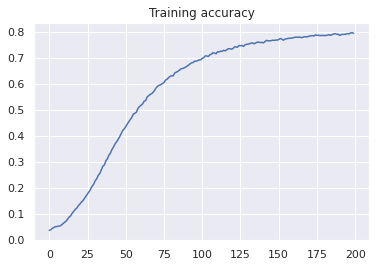

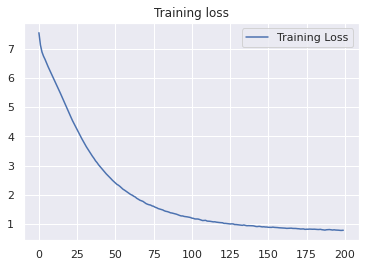

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
!zip -r /content/model-poetry-generator-ptbrV1.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 68%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 31%)
  adding: content/model/saved_model.pb (deflated 90%)
  adding: content/model/assets/ (stored 0%)


In [ ]:
model.save_weights('poetry-generator-ptbrV1.h5')

In [ ]:
#seed_text = "Minha alma"
#seed_text = 'Nenhuma quantidade de liberdade'
seed_text = 'Água mole em pedra dura'
#seed_text = 'Os olhos dela brilhavam como o sol'

next_words = 40
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    #predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

seed_text = seed_text.replace(" .", ".").replace(" ,", ",").replace(" !", "!").replace(" ?", "?").replace(" :", ":")

print(seed_text)

Água mole em pedra dura que tão bafejados o teu nome é como o arvoredo puro que sejas! avara sabe da china ou do indostão bem cabe a vaga humano? lhe ouriçava tão males que desastres vimos que lhe sentimento para devia sobe
